In [174]:
import requests 
from functools import partial

# base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
# relative_url = '03-vector-search/eval/documents-with-ids.json'
# docs_url = f'{base_url}/{relative_url}?raw=1'
# docs_response = requests.get(docs_url)
# documents = docs_response.json()

In [1]:
import json

In [6]:
with open ("../03-vector-search/eval/documents-with-ids.json", "rt") as f_out:
    documents = json.load(f_out)

In [9]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

## Load ground truth

In [11]:
import pandas as pd

# base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
# relative_url = '03-vector-search/eval/ground-truth-data.csv'
# ground_truth_url = f'{base_url}/{relative_url}?raw=1'

# df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = pd.read_csv("../03-vector-search/eval/ground-truth-data.csv") 
print(df_ground_truth.shape)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
print(df_ground_truth.shape)
ground_truth = df_ground_truth.to_dict(orient='records')

(4631, 3)
(1842, 3)


In [17]:
print(f"ground truth {ground_truth[0]}\n")
print(f"\ndocument {documents[0]}")

ground truth {'question': 'Can you explain the purpose of the Machine Learning Zoomcamp FAQ document?', 'course': 'machine-learning-zoomcamp', 'document': '0227b872'}


document {'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.", 'section': 'General course-related questions', 'question': 'Course - When will the course start?', 'course': 'data-engineering-zoomcamp', 'id': 'c02e79ef'}


In [24]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [27]:
doc_with_idx = {d["id"]: d for d in documents}

In [29]:
doc_with_idx ['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [35]:
type(doc_with_idx), doc_with_idx

(dict,
 {'c02e79ef': {'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
   'section': 'General course-related questions',
   'question': 'Course - When will the course start?',
   'course': 'data-engineering-zoomcamp',
   'id': 'c02e79ef'},
  '1f6520ca': {'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
   'section': 'General course-related questions',
   'question': 'Course - What are the prerequisites for this course?',
   'course': 'data-engineering-zoomcamp',
   'id': '1f6520ca'},
  '7842b56a': {'text': "Yes, even if you don't register, yo

In [34]:
len(doc_with_idx), len(documents)

(947, 948)

In [36]:
doc_with_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

In [37]:

from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/mnt/d/repos/llm-zoomcamp/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [39]:
encoded_text = model.encode("This is to test the model")
encoded_text.shape

(384,)

In [41]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [42]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(f'{question} {text}')

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

In [44]:
# documents

## Retrieval

In [45]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [46]:
dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
)

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [47]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

In [48]:
resp = question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

In [53]:
resp[0].items()

dict_items([('question', 'What if I miss a session?'), ('course', 'machine-learning-zoomcamp'), ('section', 'General course-related questions'), ('text', 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'), ('id', '5170565b')])

## The RAG flow

In [54]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [55]:

from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [56]:
# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [57]:
ground_truth[10]

{'question': 'question1',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [105]:
ground_truth[11]

{'question': 'Will we learn gradient update rules for logistic regression?',
 'course': 'machine-learning-zoomcamp',
 'document': 'ecca790c'}

In [106]:
# ground_truth.pop(10)

In [66]:
doc_with_idx["5170565b"]

{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'section': 'General course-related questions',
 'question': 'What if I miss a session?',
 'course': 'machine-learning-zoomcamp',
 'id': '5170565b',
 'question_text_vector': array([ 1.32523086e-02, -1.98018625e-02,  5.15649393e-02,  4.29888517e-02,
         4.17650416e-02,  4.24587689e-02, -3.94513365e-03, -7.11748526e-02,
         9.12967175e-02,  2.65274271e-02, -8.09141770e-02,  1.07394680e-02,
        -6.65010437e-02, -4.39893864e-02,  7.16710687e-02, -2.92526055e-02,
         8.89779441e-03, -6.87785298e-02, -9.16374773e-02,  6.99334815e-02,
        -8.20276886e-02, -1.49950953e-02, -3.78887281e-02,  2.85062082e-02,
         2.37329770e-02,  1.23802740e-02, -1.19731957e-02,  7.40920566e-03,
         1.75480230e-03,  4.18143207e-03, -5.27748428e-02, -9.52396467e-

In [108]:
ground_truth[10]

{'question': 'How in-depth is the theory covered in this course?',
 'course': 'machine-learning-zoomcamp',
 'document': 'ecca790c'}

In [107]:
rag(ground_truth[10])

'The theory covered in this course is minimal and focused on an intuitive level. The primary emphasis is on practice. For instance, the course does not go into detailed derivations like the gradient update rule for logistic regression, but instead, it covers how to use logistic regression and interpret the results.'

In [109]:
doc_with_idx['ecca790c']['text']

"The bare minimum. The focus is more on practice, and we'll cover the theory only on the intuitive level.: https://mlbookcamp.com/article/python\nFor example, we won't derive the gradient update rule for logistic regression (there are other great courses for that), but we'll cover how to use logistic regression and make sense of the results."

In [110]:

answer_orig = "The bare minimum. The focus is more on practice, and we'll cover the theory only on the intuitive level.: https://mlbookcamp.com/article/python\nFor example, we won't derive the gradient update rule for logistic regression (there are other great courses for that), but we'll cover how to use logistic regression and make sense of the results."
answer_llm = 'The theory covered in this course is minimal and focused on an intuitive level. The primary emphasis is on practice. For instance, the course does not go into detailed derivations like the gradient update rule for logistic regression, but instead, it covers how to use logistic regression and interpret the results.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.7487281

In [111]:

len(ground_truth)

1837

In [113]:
for i, rec in enumerate(tqdm(ground_truth)):
    print(i)
    print(rec)
    break

  0%|          | 0/1837 [00:00<?, ?it/s]

0
{'question': 'Can you explain the purpose of the Machine Learning Zoomcamp FAQ document?', 'course': 'machine-learning-zoomcamp', 'document': '0227b872'}


In [117]:
df_ground_truth["document"].nunique()

374

In [120]:
answers = {}
for i, rec in enumerate(tqdm(ground_truth)):
    # if i in answers:
    #     continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_with_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [119]:
answers

{0: {'answer_llm': 'The purpose of the Machine Learning Zoomcamp FAQ document is to capture frequently asked technical questions related to the course. This approach has been previously used for their data engineering course and was found to be quite effective. The document serves as a resource for structuring and answering common queries that participants might have.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Can you explain the purpose of the Machine Learning Zoomcamp FAQ document?',
  'course': 'machine-learning-zoomcamp'},
 1: {'answer_llm': 'You can find inspiratio

In [ ]:
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [ ]:
import pandas as pd

In [123]:

# df_gpt4o = pd.DataFrame(results_gpt4o)

In [124]:
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '04-monitoring/data/results-gpt4o.csv'
gpt4o_url = f'{base_url}/{relative_url}?raw=1'

df_gpt4o = pd.read_csv(gpt4o_url )

In [125]:
df_gpt4o.head()

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [129]:
df_gpt4o[df_gpt4o["document"]=="d59d8df7"].iloc[0]["answer_llm"]

'We should transform the target variable to a logarithm distribution when the target variable has a long tail distribution, such as prices, with a wide range of values. This transformation is not necessary for all machine learning projects, but it is useful when the target variable is highly skewed. Plotting the distribution of the target variable is a simple way to evaluate its skewness and determine if a log transformation is appropriate. However, this method will not work if the target variable contains negative values.'

In [132]:
df_gpt4o[df_gpt4o["document"]=="d59d8df7"].iloc[0]["answer_orig"]

'Why should we transform the target variable to logarithm distribution? Do we do this for all machine learning projects?\nOnly if you see that your target is highly skewed. The easiest way to evaluate this is by plotting the distribution of the target variable.\nThis can help to understand skewness and how it can be applied to the distribution of your data set.\nhttps://en.wikipedia.org/wiki/Skewness\nPastor Soto'

In [137]:
# !mkdir data

In [138]:

df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

## Evaluating GPT 3.5

In [139]:
rag(ground_truth[10], model='gpt-3.5-turbo')

'The theory covered in this course is at the bare minimum. The focus is more on practice, and the theory is covered only on an intuitive level.'

In [141]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=10)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [171]:
def process_record(rec, model='gpt-3.5-turbo'):
    # model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_with_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [143]:
process_record(ground_truth[10])

{'answer_llm': 'The theory in this course is covered at a bare minimum level. The focus is more on practice, and only intuitive level theory will be covered.',
 'answer_orig': "The bare minimum. The focus is more on practice, and we'll cover the theory only on the intuitive level.: https://mlbookcamp.com/article/python\nFor example, we won't derive the gradient update rule for logistic regression (there are other great courses for that), but we'll cover how to use logistic regression and make sense of the results.",
 'document': 'ecca790c',
 'question': 'How in-depth is the theory covered in this course?',
 'course': 'machine-learning-zoomcamp'}

In [144]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

  0%|          | 0/1837 [00:00<?, ?it/s]

In [145]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [146]:

!head data/results-gpt35.csv

answer_llm,answer_orig,document,question,course
The purpose of the Machine Learning Zoomcamp FAQ document is to capture frequently asked technical questions.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Can you explain the purpose of the Machine Learning Zoomcamp FAQ document?,machine-learning-zoomcamp
You can find inspiration on how to structure your questions and answers by checking the Data Engineering Zoomcamp FAQ document. You can access it through the course GitHub repository at the following link: https://airtable.com/shryxwLd0COOEaqXo,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently a

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

## gpt-4o

In [147]:

results_gpt4o = df_gpt4o.to_dict(orient='records')

In [148]:
record = results_gpt4o[0]

In [149]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [150]:
compute_similarity(record)

0.53453267

In [151]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [152]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995338
Name: cosine, dtype: float64

In [154]:
import seaborn as sns

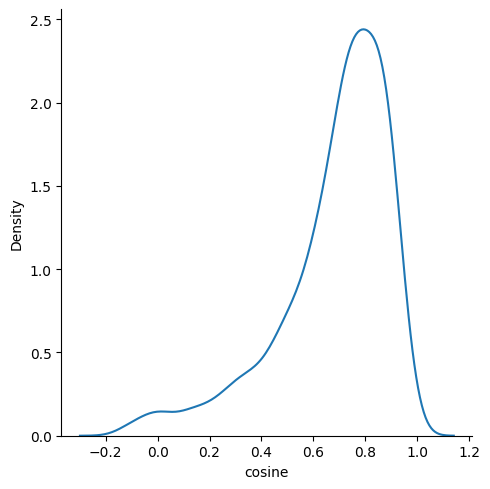

In [162]:
sns.displot(df_gpt4o['cosine'], kind="kde")

## gpt-3.5-turbo

In [155]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1837 [00:00<?, ?it/s]

In [156]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1837.000000
mean        0.661893
std         0.224831
min        -0.151913
25%         0.562504
50%         0.713862
75%         0.820601
max         0.999273
Name: cosine, dtype: float64

In [169]:
import matplotlib.pyplot as plt

/tmp/ipykernel_5298/1160418418.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label="3.5")
/tmp/ipykernel_5298/1160418418.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label="4.o")


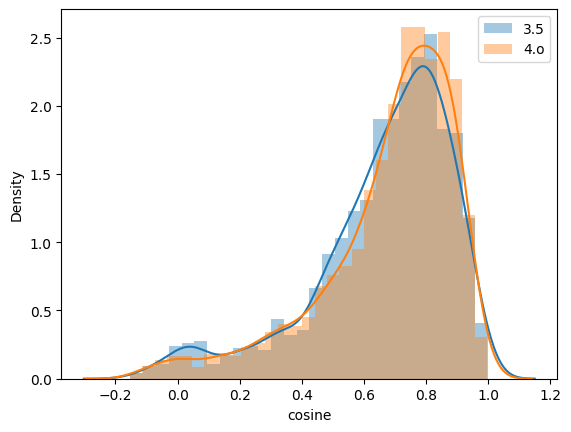

In [170]:
sns.distplot(df_gpt35['cosine'], label="3.5")
sns.distplot(df_gpt4o['cosine'], label="4.o")
plt.legend()

### gpt-4o-mini

In [172]:
process_record(ground_truth[0], model='gpt-4o-mini')

{'answer_llm': 'The purpose of the Machine Learning Zoomcamp FAQ document is to capture frequently asked technical questions. This approach was effective in a previous course focused on data engineering, and the FAQ aims to provide a structured format for addressing questions and answers relevant to the course participants.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Can you explain the purpose of the Machine Learning Zoomcamp FAQ document?',
 'course': 'machine-learning-zoomcamp'}

In [175]:
process_record_with_model = partial(process_record, model='gpt-4o-mini')
results_gpt4omini = map_progress(pool, ground_truth, process_record_with_model )

  0%|          | 0/1837 [00:00<?, ?it/s]

In [179]:
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [176]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/1837 [00:00<?, ?it/s]

In [181]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1837.000000
mean        0.680549
std         0.222740
min        -0.163064
25%         0.583817
50%         0.742502
75%         0.840594
max         0.991410
Name: cosine, dtype: float64

/tmp/ipykernel_5298/378714617.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_5298/378714617.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')
/tmp/ipykernel_5298/378714617.py:5: UserWarning: 

`distpl

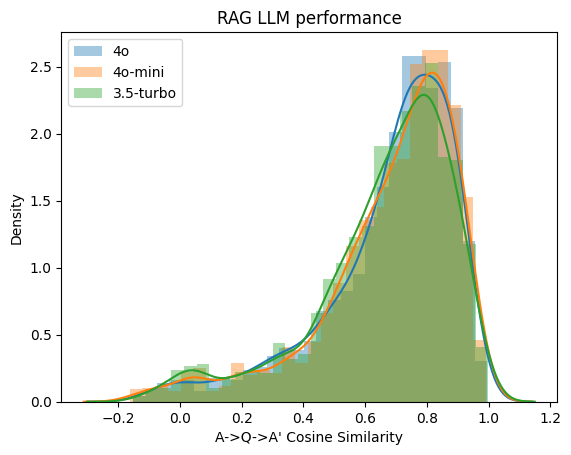

In [183]:
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')
sns.distplot(df_gpt35['cosine'], label='3.5-turbo')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

### LLM-as-a-Judge

In [184]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [185]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [186]:

samples = df_sample.to_dict(orient='records')

In [187]:

record = samples[0]
record

{'answer_llm': 'It is better to use DictVectorizer when you want to preserve feature names in the transformed data and have a small number of unique values. On the other hand, FeatureHasher is more suitable when you have high cardinality for categorical features. Your choice will ultimately depend on your specific data.',
 'answer_orig': 'These both methods receive the dictionary as an input. While the DictVectorizer will store the big vocabulary and takes more memory. FeatureHasher create a vectors with predefined length. They are both used for categorical features.\nWhen you have a high cardinality for categorical features better to use FeatureHasher. If you want to preserve feature names in transformed data and have a small number of unique values is DictVectorizer. But your choice will dependence on your data.\nYou can read more by follow the link https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.html\nOlga Rudakova',
 'document': '690d97f1',
 'ques

In [188]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: These both methods receive the dictionary as an input. While the DictVectorizer will store the big vocabulary and takes more memory. FeatureHasher create a vectors with predefined length. They are both used for categorical features.
When you have a high cardinality for categorical features better to use FeatureHasher. If you want to preserve feature names in transformed data and have a small number of unique values is DictVectorizer. But your choice will dependence on your data.
You can read more by follow the link https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.h

In [189]:
llm(prompt, model='gpt-4o-mini')

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer accurately reflects the key points from the original answer, specifically mentioning when to use DictVectorizer and FeatureHasher. It captures the essence of the decision-making process regarding the choice between these two methods, aligning well with the context and details provided in the original answer."\n}'

In [190]:
import json

In [191]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [192]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

JSONDecodeError: Expecting property name enclosed in double quotes: line 4 column 1 (char 408)

In [193]:
json_evaluations

[{'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer correctly identifies the scenarios in which DictVectorizer is preferred over FeatureHasher, mirroring the important points made in the original answer. It accurately conveys the same concepts regarding preserving feature names and high cardinality, providing a clear and concise response to the question posed.'},
 {'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer directly addresses the question by specifying the correct file to edit, providing the necessary JSON content to add, and including the command to restart Docker. It aligns closely with the original answer in both content and context, making it highly relevant.'},
 {'Relevance': 'RELEVANT',
  'Explanation': "The generated answer closely follows the original answer's proposed solution for resolving Docker daemon connection issues in WSL. It accurately outlines the specific steps required to enable WSL integration in Docker Desktop, which is the prima

In [ ]:
df_evaluations = pd.DataFrame(json_evaluations)